In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-de04l26y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-de04l26y
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
! nvidia-smi

Mon Apr 21 20:46:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
import clip
from PIL import Image
import cv2
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

In [4]:
class CLIPKeyFrameExtractor:
    def __init__(self, clip_model_name: str = "ViT-B/32"):
        """
        Initialize the CLIP-based key frame extractor.

        Args:
            clip_model_name: The CLIP model variant to use
        """
        # Load the CLIP model
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(clip_model_name, device=self.device)
        print(f"CLIP model loaded on {self.device}")

    def extract_frames(self, video_path: str, sample_rate: int = 1) -> List[np.ndarray]:
        """
        Extract frames from the video at the given sample rate.

        Args:
            video_path: Path to the video file
            sample_rate: Sample every nth frame (default: 1, i.e., extract all frames)

        Returns:
            List of extracted frames as numpy arrays
        """
        frames = []
        frame_indices = []

        # Open the video file
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")

        # Get total frames for progress reporting
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        print(f"Video has {total_frames} frames at {fps} FPS")

        # Extract frames
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx % sample_rate == 0:
                # Convert BGR to RGB (OpenCV uses BGR by default)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)
                frame_indices.append(frame_idx)

            frame_idx += 1

            # Print progress every 100 frames
            if frame_idx % 100 == 0:
                print(f"Processed {frame_idx}/{total_frames} frames ({frame_idx/total_frames:.1%})")

        cap.release()
        print(f"Extracted {len(frames)} frames at sample rate {sample_rate}")
        return frames, frame_indices, fps

    def get_frame_timestamps(self, frame_indices: List[int], fps: float) -> List[float]:
        """
        Convert frame indices to timestamps in seconds.

        Args:
            frame_indices: List of frame indices
            fps: Frames per second of the video

        Returns:
            List of timestamps in seconds
        """
        return [idx / fps for idx in frame_indices]

    def encode_question(self, question: str) -> torch.Tensor:
        """
        Encode the question using CLIP's text encoder.

        Args:
            question: The question text

        Returns:
            The encoded question tensor
        """
        # Tokenize and encode the question
        with torch.no_grad():
            text_inputs = clip.tokenize([question]).to(self.device)
            question_features = self.model.encode_text(text_inputs)
            # Normalize the features
            question_features = question_features / question_features.norm(dim=-1, keepdim=True)

        return question_features

    def encode_frames(self, frames: List[np.ndarray]) -> torch.Tensor:
        """
        Encode the frames using CLIP's image encoder.

        Args:
            frames: List of frames as numpy arrays

        Returns:
            The encoded frame tensors
        """
        frame_features = []

        # Process frames in batches to avoid memory issues
        batch_size = 32
        num_frames = len(frames)

        for i in range(0, num_frames, batch_size):
            batch_frames = frames[i:i + batch_size]

            # Preprocess the batch of frames
            preprocessed_frames = torch.stack([
                self.preprocess(Image.fromarray(frame))
                for frame in batch_frames
            ]).to(self.device)

            # Encode the batch of frames
            with torch.no_grad():
                batch_features = self.model.encode_image(preprocessed_frames)
                # Normalize the features
                batch_features = batch_features / batch_features.norm(dim=-1, keepdim=True)

            frame_features.append(batch_features)

            print(f"Encoded frames {i} to {min(i + batch_size, num_frames)}/{num_frames}")

        # Concatenate all batches
        frame_features = torch.cat(frame_features, dim=0)

        return frame_features

    def compute_similarities(self, question_features: torch.Tensor, frame_features: torch.Tensor) -> torch.Tensor:
        """
        Compute the cosine similarities between the question and all frames.

        Args:
            question_features: The encoded question
            frame_features: The encoded frames

        Returns:
            Tensor of similarity scores for each frame
        """
        # Compute cosine similarities
        similarities = (100.0 * question_features @ frame_features.T).squeeze()

        return similarities

    def select_key_frames(
        self,
        similarities: torch.Tensor,
        frames: List[np.ndarray],
        frame_indices: List[int],
        timestamps: List[float],
        top_k: int = 5,
        similarity_threshold: float = None,
        min_distance: int = 0
    ) -> Dict:
        """
        Select the top-k most relevant frames based on similarity scores.

        Args:
            similarities: Tensor of similarity scores
            frames: List of all extracted frames
            frame_indices: List of frame indices
            timestamps: List of frame timestamps
            top_k: Number of key frames to select
            similarity_threshold: Minimum similarity score required (optional)
            min_distance: Minimum distance between selected frames in terms of indices

        Returns:
            Dictionary containing selected frames, indices, timestamps, and scores
        """
        # Convert similarities to numpy array
        similarities_np = similarities.cpu().numpy()

        # Apply threshold if provided
        if similarity_threshold is not None:
            valid_indices = np.where(similarities_np >= similarity_threshold)[0]
            if len(valid_indices) == 0:
                print(f"No frames with similarity >= {similarity_threshold} found.")
                # Fall back to top-k without threshold
                valid_indices = np.arange(len(similarities_np))
        else:
            valid_indices = np.arange(len(similarities_np))

        # Get top-k indices with minimum distance constraint
        selected_indices = []

        # Sort valid indices by similarity score (descending)
        sorted_indices = valid_indices[np.argsort(-similarities_np[valid_indices])]

        for idx in sorted_indices:
            # Check if the current index is far enough from already selected indices
            if all(abs(idx - selected_idx) >= min_distance for selected_idx in selected_indices) or not selected_indices:
                selected_indices.append(idx)

            # Stop when we have enough frames
            if len(selected_indices) >= top_k:
                break

        # If we couldn't find enough frames with the distance constraint, relax it
        if len(selected_indices) < top_k and min_distance > 0:
            print(f"Could only find {len(selected_indices)} frames with min_distance={min_distance}.")
            print("Relaxing distance constraint...")
            remaining = top_k - len(selected_indices)

            # Consider indices not yet selected
            remaining_indices = [idx for idx in sorted_indices if idx not in selected_indices]
            selected_indices.extend(remaining_indices[:remaining])

        # Sort selected indices by their position in the video
        selected_indices.sort()

        # Gather the selected frames, their original indices, timestamps, and scores
        key_frames = [frames[idx] for idx in selected_indices]
        key_frame_indices = [frame_indices[idx] for idx in selected_indices]
        key_timestamps = [timestamps[idx] for idx in selected_indices]
        key_scores = [similarities_np[idx] for idx in selected_indices]

        return {
            "frames": key_frames,
            "indices": key_frame_indices,
            "timestamps": key_timestamps,
            "scores": key_scores
        }

    def visualize_key_frames(self, key_frames_data: Dict, question: str, output_path: str = None):
        """
        Visualize the selected key frames with their similarity scores.

        Args:
            key_frames_data: Dictionary containing key frames data
            question: The original question
            output_path: Path to save the visualization (optional)
        """
        key_frames = key_frames_data["frames"]
        scores = key_frames_data["scores"]
        timestamps = key_frames_data["timestamps"]

        n_frames = len(key_frames)

        # Set up the figure
        fig, axes = plt.subplots(1, n_frames, figsize=(n_frames * 4, 5))
        if n_frames == 1:
            axes = [axes]

        # Set the figure title to the question
        fig.suptitle(f"Question: {question}", fontsize=16)

        # Plot each key frame
        for i, (frame, score, timestamp) in enumerate(zip(key_frames, scores, timestamps)):
            axes[i].imshow(frame)
            axes[i].set_title(f"Score: {score:.2f}\nTime: {timestamp:.2f}s")
            axes[i].axis("off")

        plt.tight_layout()

        # Save the figure if output path is provided
        if output_path:
            plt.savefig(output_path, dpi=150, bbox_inches="tight")
            print(f"Visualization saved to {output_path}")

        plt.show()

    def extract_key_frames(self, video_path: str, question: str, sample_rate: int = 1,
        top_k: int = 5, similarity_threshold: float = None, min_distance: int = 0,
        visualize: bool = True, output_path: str = None) -> Dict:
        """
        Extract key frames from a video that are most relevant to the given question.

        Args:
            video_path: Path to the video file
            question: The question about the video
            sample_rate: Sample every nth frame
            top_k: Number of key frames to extract
            similarity_threshold: Minimum similarity score required
            min_distance: Minimum distance between selected frames
            visualize: Whether to visualize the results
            output_path: Path to save the visualization

        Returns:
            Dictionary containing key frames data
        """
        print(f"Processing video: {video_path}")
        print(f"Question: {question}")

        # Extract frames from the video
        frames, frame_indices, fps = self.extract_frames(video_path, sample_rate)
        timestamps = self.get_frame_timestamps(frame_indices, fps)

        # Encode the question
        question_features = self.encode_question(question)

        # Encode the frames
        frame_features = self.encode_frames(frames)

        # Compute similarities between question and frames
        similarities = self.compute_similarities(question_features, frame_features)

        # Select key frames based on similarities
        key_frames_data = self.select_key_frames(
            similarities, frames, frame_indices, timestamps,
            top_k, similarity_threshold, min_distance
        )

        # Visualize the results if requested
        if visualize:
            self.visualize_key_frames(key_frames_data, question, output_path)

        return key_frames_data


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 87.4MiB/s]


CLIP model loaded on cuda
Downloading...
From: https://drive.google.com/uc?id=1LYzNuZr9kfK0EtKTDiWCxetzJ8fYzdlb
To: /content/example.mp4
100% 1.63M/1.63M [00:00<00:00, 211MB/s]
Processing video: ./example.mp4
Question: What is the person able to do after walking through the doorway?
Video has 930 frames at 30.0 FPS
Processed 100/930 frames (10.8%)
Processed 200/930 frames (21.5%)
Processed 300/930 frames (32.3%)
Processed 400/930 frames (43.0%)
Processed 500/930 frames (53.8%)
Processed 600/930 frames (64.5%)
Processed 700/930 frames (75.3%)
Processed 800/930 frames (86.0%)
Processed 900/930 frames (96.8%)
Extracted 186 frames at sample rate 5
Encoded frames 0 to 32/186
Encoded frames 32 to 64/186
Encoded frames 64 to 96/186
Encoded frames 96 to 128/186
Encoded frames 128 to 160/186
Encoded frames 160 to 186/186
Visualization saved to key_frames.png


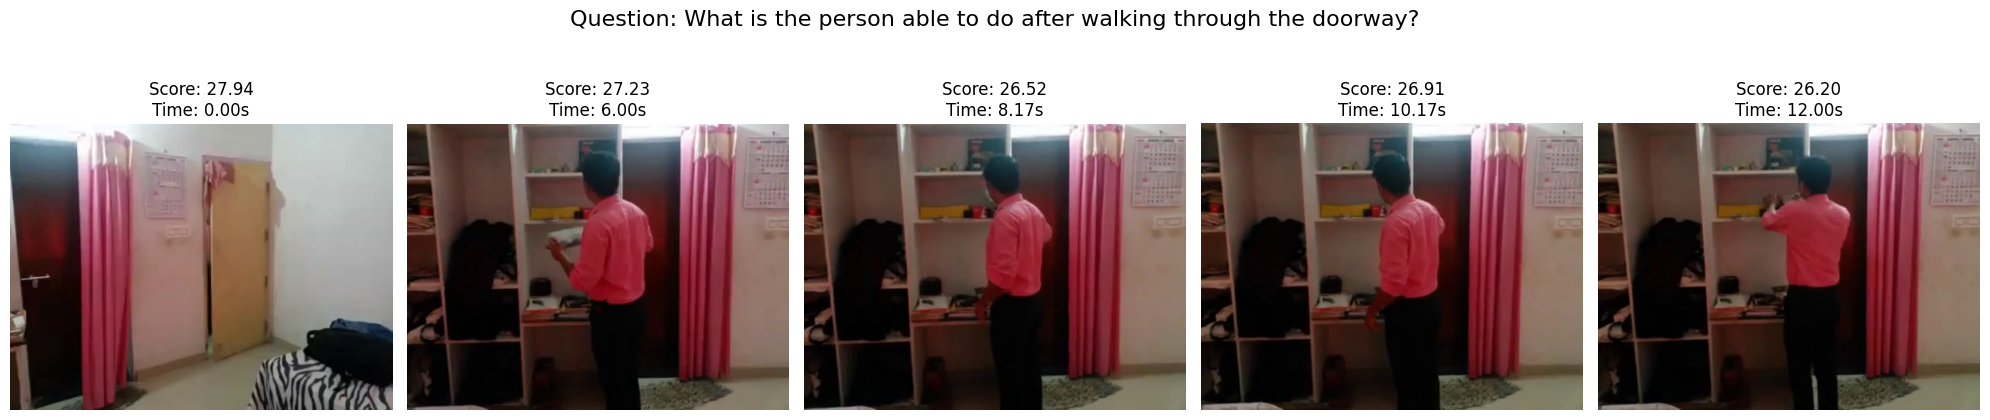

In [5]:
# Initialize the extractor with the CLIP model
extractor = CLIPKeyFrameExtractor()

# example video and question
! gdown 1LYzNuZr9kfK0EtKTDiWCxetzJ8fYzdlb -O example.mp4
video_path = "./example.mp4"
question = "What is the person able to do after walking through the doorway?"

key_frames_data = extractor.extract_key_frames(
    video_path=video_path,
    question=question,
    sample_rate=5,  # Sample every 5 frames to speed up processing
    top_k=5,  # Extract the 5 most relevant frames
    min_distance=10,  # Ensure frames are at least 10 indices apart
    visualize=True,  # Visualize the selected key frames
    output_path="key_frames.png"  # Save the visualization to a file
)

In [6]:
print(f"Extracted {len(key_frames_data['frames'])} key frames")
for i, (idx, timestamp, score) in enumerate(zip(
    key_frames_data['indices'],
    key_frames_data['timestamps'],
    key_frames_data['scores']
)):
    print(f"Frame {i+1}: index={idx}, timestamp={timestamp:.2f}s, similarity={score:.2f}")

Extracted 5 key frames
Frame 1: index=0, timestamp=0.00s, similarity=27.94
Frame 2: index=180, timestamp=6.00s, similarity=27.23
Frame 3: index=245, timestamp=8.17s, similarity=26.52
Frame 4: index=305, timestamp=10.17s, similarity=26.91
Frame 5: index=360, timestamp=12.00s, similarity=26.20
